In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
file_path = '/Users/Pato/Dev/Python/data_temps/ML_Templates/logistic regression/data/log_reg_cleaning.csv'

data = pd.read_csv(file_path)

target_variable = 'Attrition'  # Replace with the actual target column


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/sw/wnh5xb2s66v5ljpzzgr4xznc0000gn/T/ipykernel_3962/3529361779.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance[:5], y=top_features[:5], palette='Greens_r', ax=ax4)
/var/folders/sw/wnh5xb2s66v5ljpzzgr4xznc0000gn/T/ipykernel_3962/3529361779.py:115: FutureWarning:

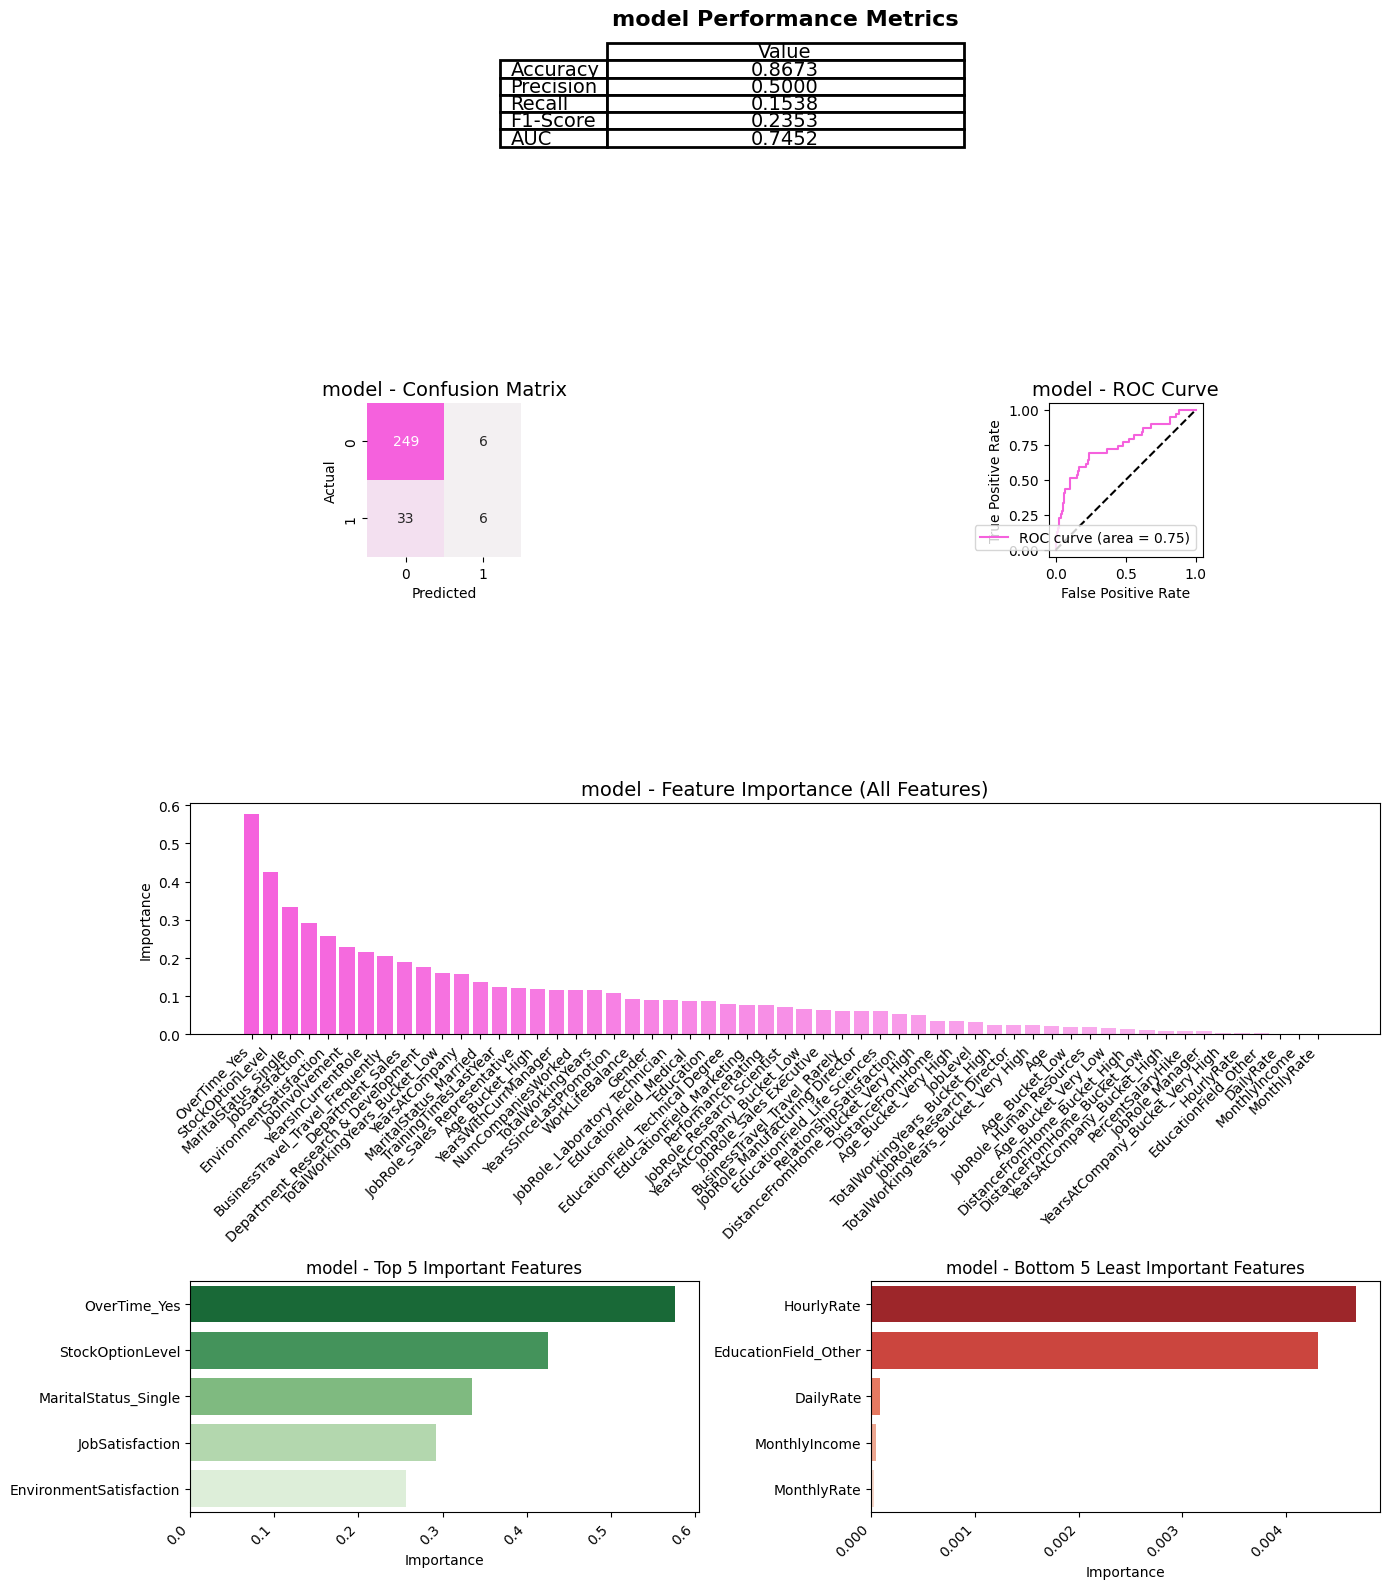

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Separate features (X) and target variable (y)
X = data.drop(target_variable, axis=1)
y = data[target_variable]

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

summarise_model(model,X_test, y_test)


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, roc_auc_score
)
from matplotlib.gridspec import GridSpec
import pandas as pd
from matplotlib.table import Table
import random
import inspect

def create_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    return y_test, y_pred, y_prob

def create_summary_stats(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }

def create_presentation_table(ax, summary_stats, model_name):
    cell_text = [[f"{value:.4f}"] for value in summary_stats.values()]
    row_labels = list(summary_stats.keys())
    
    table = ax.table(cellText=cell_text, rowLabels=row_labels, colLabels=["Value"],
                     cellLoc='center', loc='center', colWidths=[0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('black')
        cell.set_linewidth(2)
    
    ax.set_title(f'{model_name} Performance Metrics', fontsize=16, fontweight='bold')
    ax.axis('off')

def logistic_regression_graphs(model, X_test, y_test, y_pred, y_prob, summary_stats, model_name):
    cm = confusion_matrix(y_test, y_pred)
    
    # Generate random color for all charts except the last two feature importance plots
    random_color = random.choice(sns.color_palette("husl", 8))
    
    fig = plt.figure(figsize=(14, 16))
    gs = GridSpec(4, 2, figure=fig, height_ratios=[0.8, 1, 1.5, 1.5])
    
    # Subplot 1: Summary Table
    ax0 = fig.add_subplot(gs[0, :])
    create_presentation_table(ax0, summary_stats, model_name)
    
    # Subplot 2: Confusion Matrix (square aspect ratio)
    ax1 = fig.add_subplot(gs[1, 0])
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.light_palette(random_color, as_cmap=True), cbar=False, ax=ax1)
    ax1.set_title(f'{model_name} - Confusion Matrix', fontsize=14)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_aspect('equal')

    # Subplot 3: ROC Curve (square aspect ratio)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})', color=random_color)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'{model_name} - ROC Curve', fontsize=14)
    ax2.legend(loc='lower right')
    ax2.set_aspect('equal')
    
    # Feature importance plot
    if hasattr(model, 'coef_'):
        feature_importance = np.abs(model.coef_[0])
        feature_names = X_test.columns
        
        sorted_idx = np.argsort(feature_importance)[::-1]
        top_features = feature_names[sorted_idx]
        top_importance = feature_importance[sorted_idx]
        
        # Subplot 4: Feature Importance (All Features) with stepped alpha
        ax3 = fig.add_subplot(gs[2, :])
        bar_colors = [random_color] * len(top_features)  # All bars have the same color
        alphas = np.linspace(1.0, 0.4, len(top_features))  # Stepped alpha from 1.0 to 0.4
        
        for i, (imp, feat) in enumerate(zip(top_importance, top_features)):
            ax3.bar(feat, imp, color=random_color, alpha=alphas[i])
        
        ax3.set_title(f'{model_name} - Feature Importance (All Features)', fontsize=14)
        ax3.set_ylabel('Importance')
        plt.xticks(rotation=45, ha='right')

        # Subplot 5: Top 5 Important Features - using shades of green
        ax4 = fig.add_subplot(gs[3, 0])
        sns.barplot(x=top_importance[:5], y=top_features[:5], palette='Greens_r', ax=ax4)
        ax4.set_title(f'{model_name} - Top 5 Important Features', fontsize=12)
        ax4.set_xlabel('Importance')
        ax4.set_ylabel('')
        plt.xticks(rotation=45, ha='right')

        # Subplot 6: Bottom 5 Least Important Features - using shades of red
        ax5 = fig.add_subplot(gs[3, 1])
        sns.barplot(x=top_importance[-5:], y=top_features[-5:], palette='Reds_r', ax=ax5)
        ax5.set_title(f'{model_name} - Bottom 5 Least Important Features', fontsize=12)
        ax5.set_xlabel('Importance')
        ax5.set_ylabel('')
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

def summarise_model(model, X_test, y_test):
    # Get the name of the variable passed as `model`
    model_name = [name for name, value in inspect.currentframe().f_back.f_locals.items() if value is model][0]
    
    y_test, y_pred, y_prob = create_predictions(model, X_test, y_test)
    summary_stats = create_summary_stats(y_test, y_pred, y_prob)
    logistic_regression_graphs(model, X_test, y_test, y_pred, y_prob, summary_stats, model_name)


/var/folders/sw/wnh5xb2s66v5ljpzzgr4xznc0000gn/T/ipykernel_3962/3529361779.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance[:5], y=top_features[:5], palette='Greens_r', ax=ax4)
/var/folders/sw/wnh5xb2s66v5ljpzzgr4xznc0000gn/T/ipykernel_3962/3529361779.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance[-5:], y=top_features[-5:], palette='Reds_r', ax=ax5)


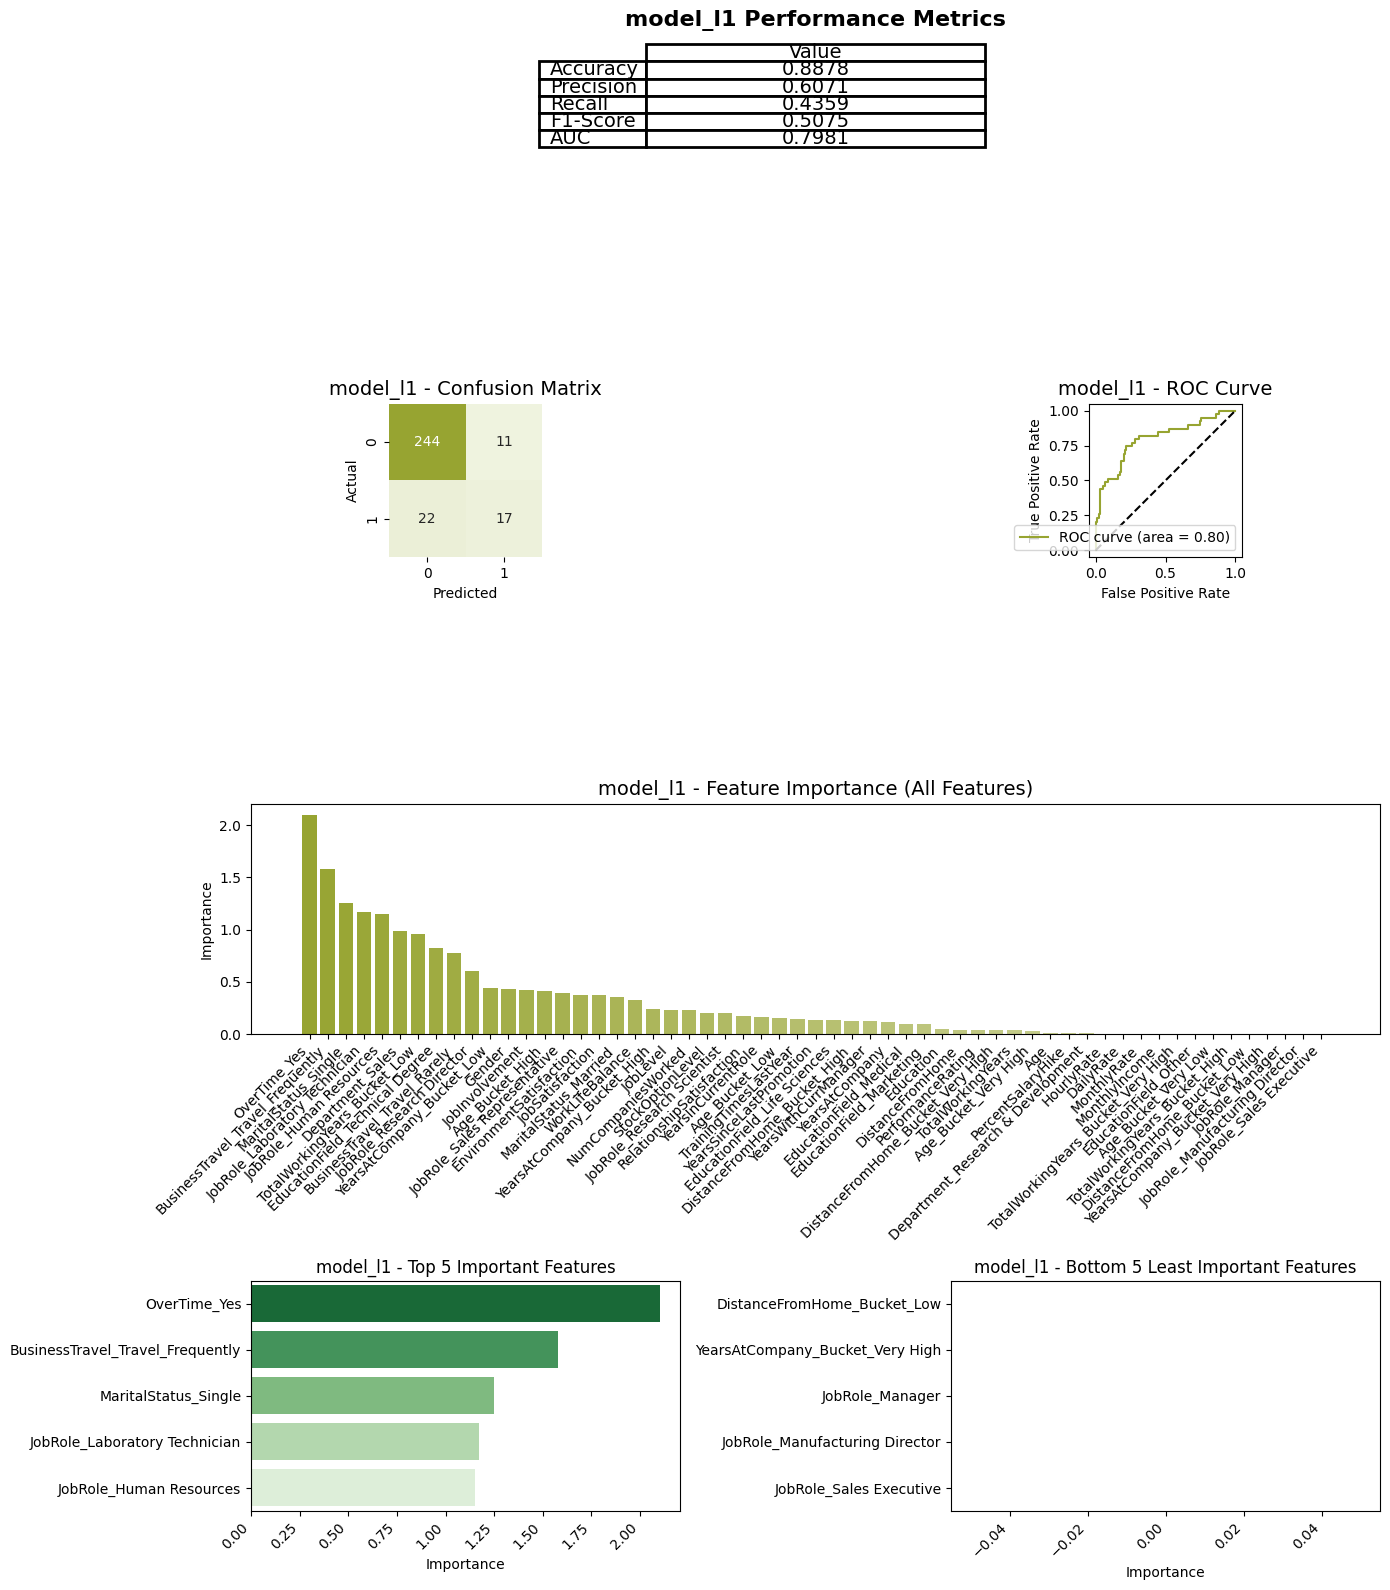

In [23]:
# L1 Regularization
model_l1 = LogisticRegression(penalty='l1', solver='liblinear')
model_l1.fit(X_train, y_train)
summarise_model(model_l1, X_test, y_test)




/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/sw/wnh5xb2s66v5ljpzzgr4xznc0000gn/T/ipykernel_3962/3529361779.py:107: FutureWarning

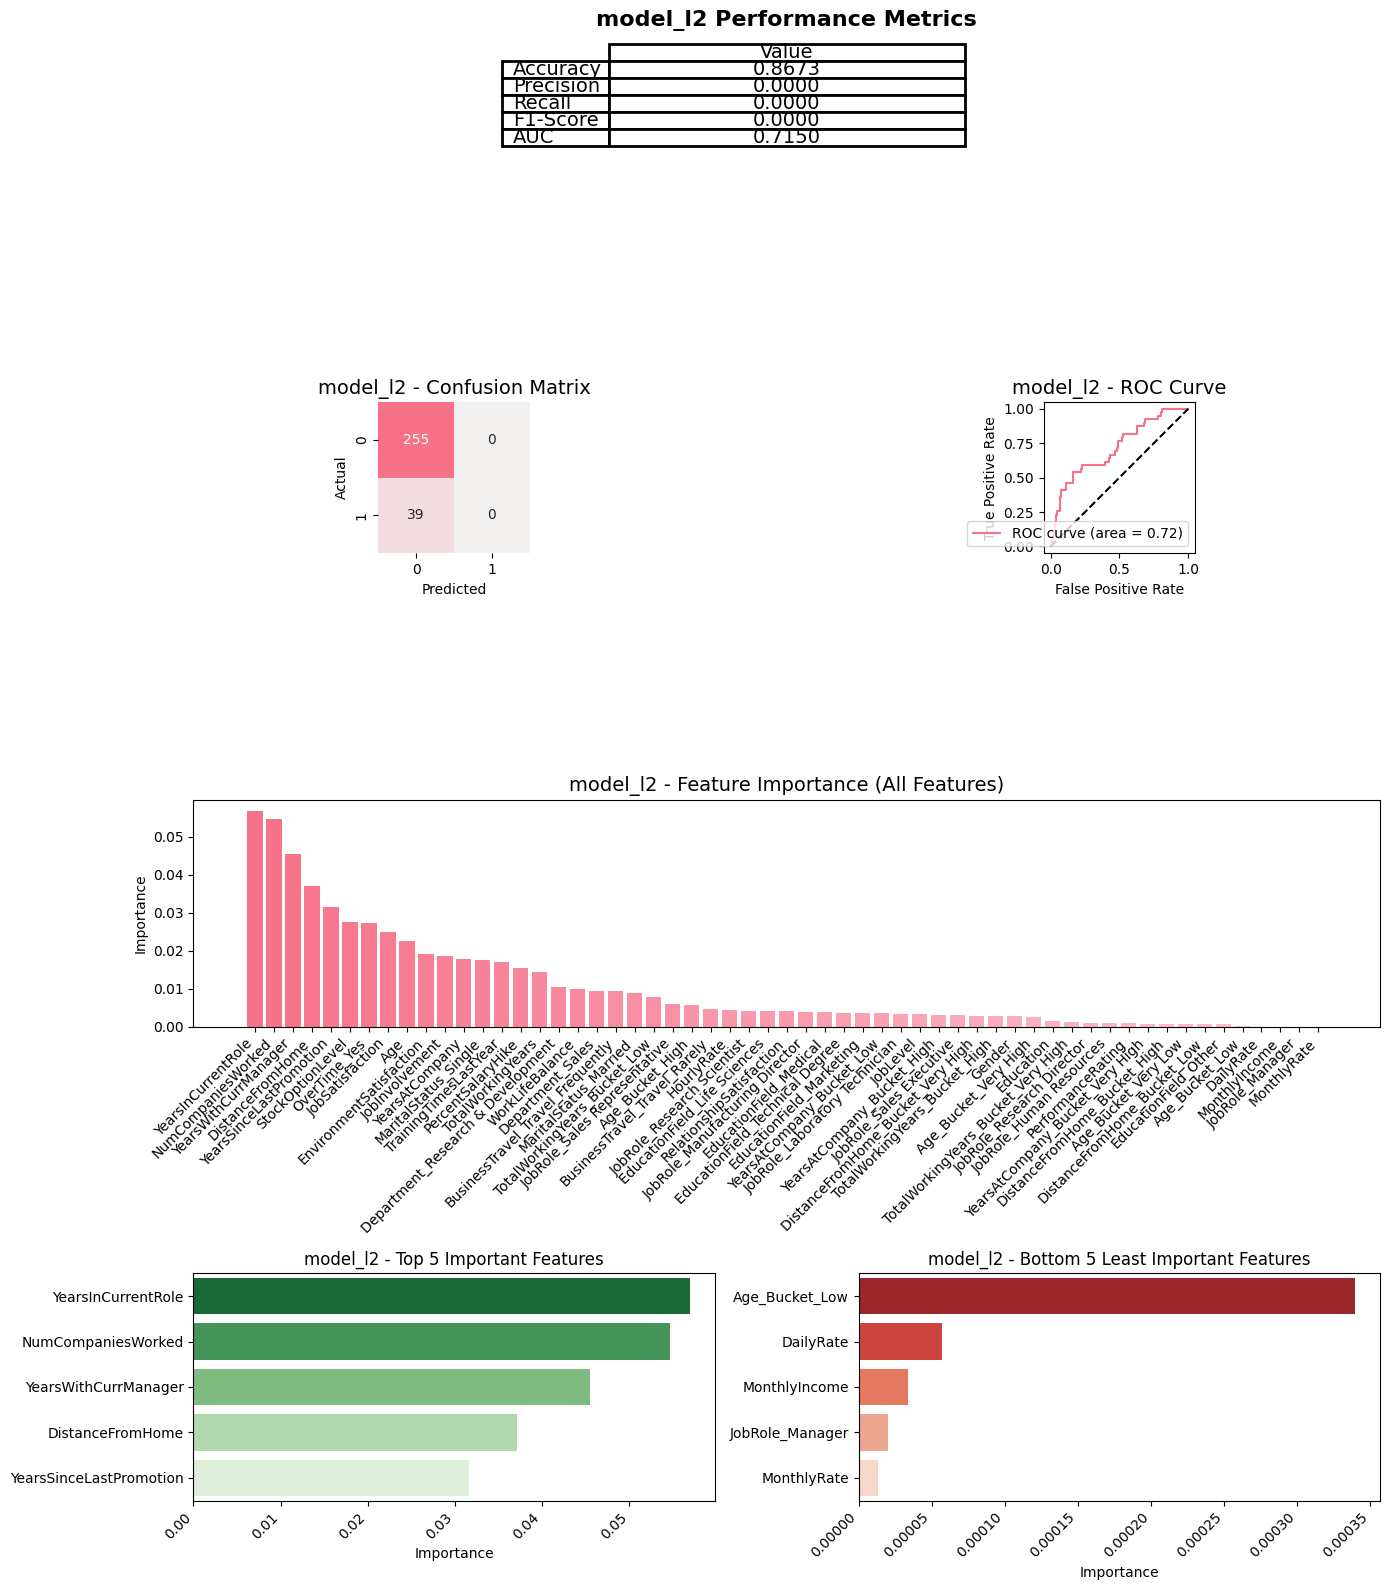

In [24]:

# L2 Regularization (default)
model_l2 = LogisticRegression(penalty='l2')
model_l2.fit(X_train, y_train)
summarise_model(model_l2, X_test, y_test)




/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

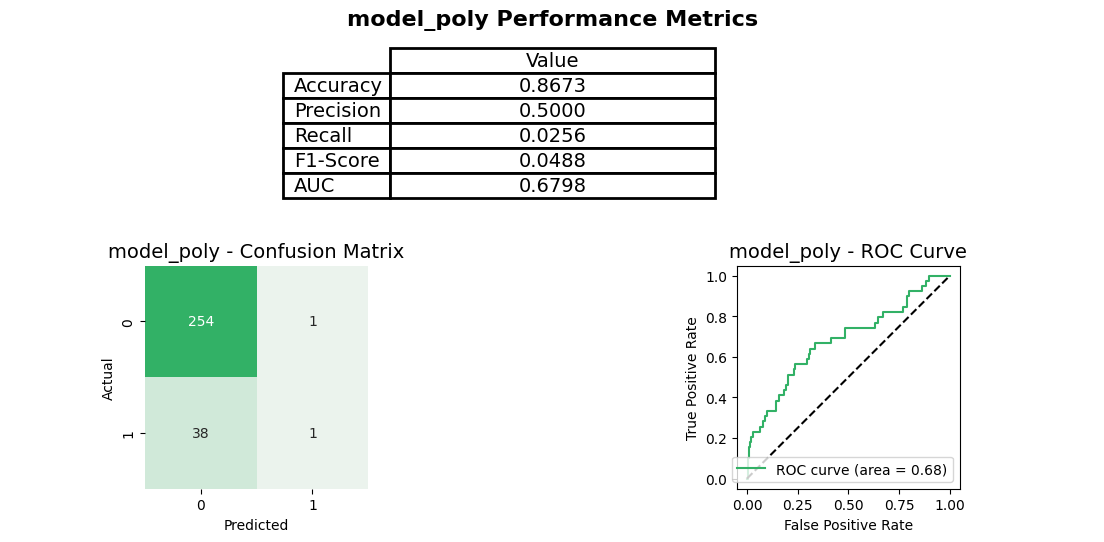

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_train)

# Logistic Regression on Polynomial Features
model_poly = LogisticRegression()
model_poly.fit(X_poly, y_train)

# Predictions and Evaluation
X_test_poly = poly.transform(X_test)
y_pred_poly = model_poly.predict(X_test_poly)

summarise_model(model_poly,X_test_poly, y_test)

/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/sw/wnh5xb2s66v5ljpzzgr4xznc0000gn/T/ipykernel_3962/3529361779.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance[:5], y=top_features[:5], palette='Greens_r', ax=ax4)
/var/folders/sw/wnh5xb2s66v5ljpzzgr4xznc0000gn/T/ipykernel_3962/3529361779.py:115:

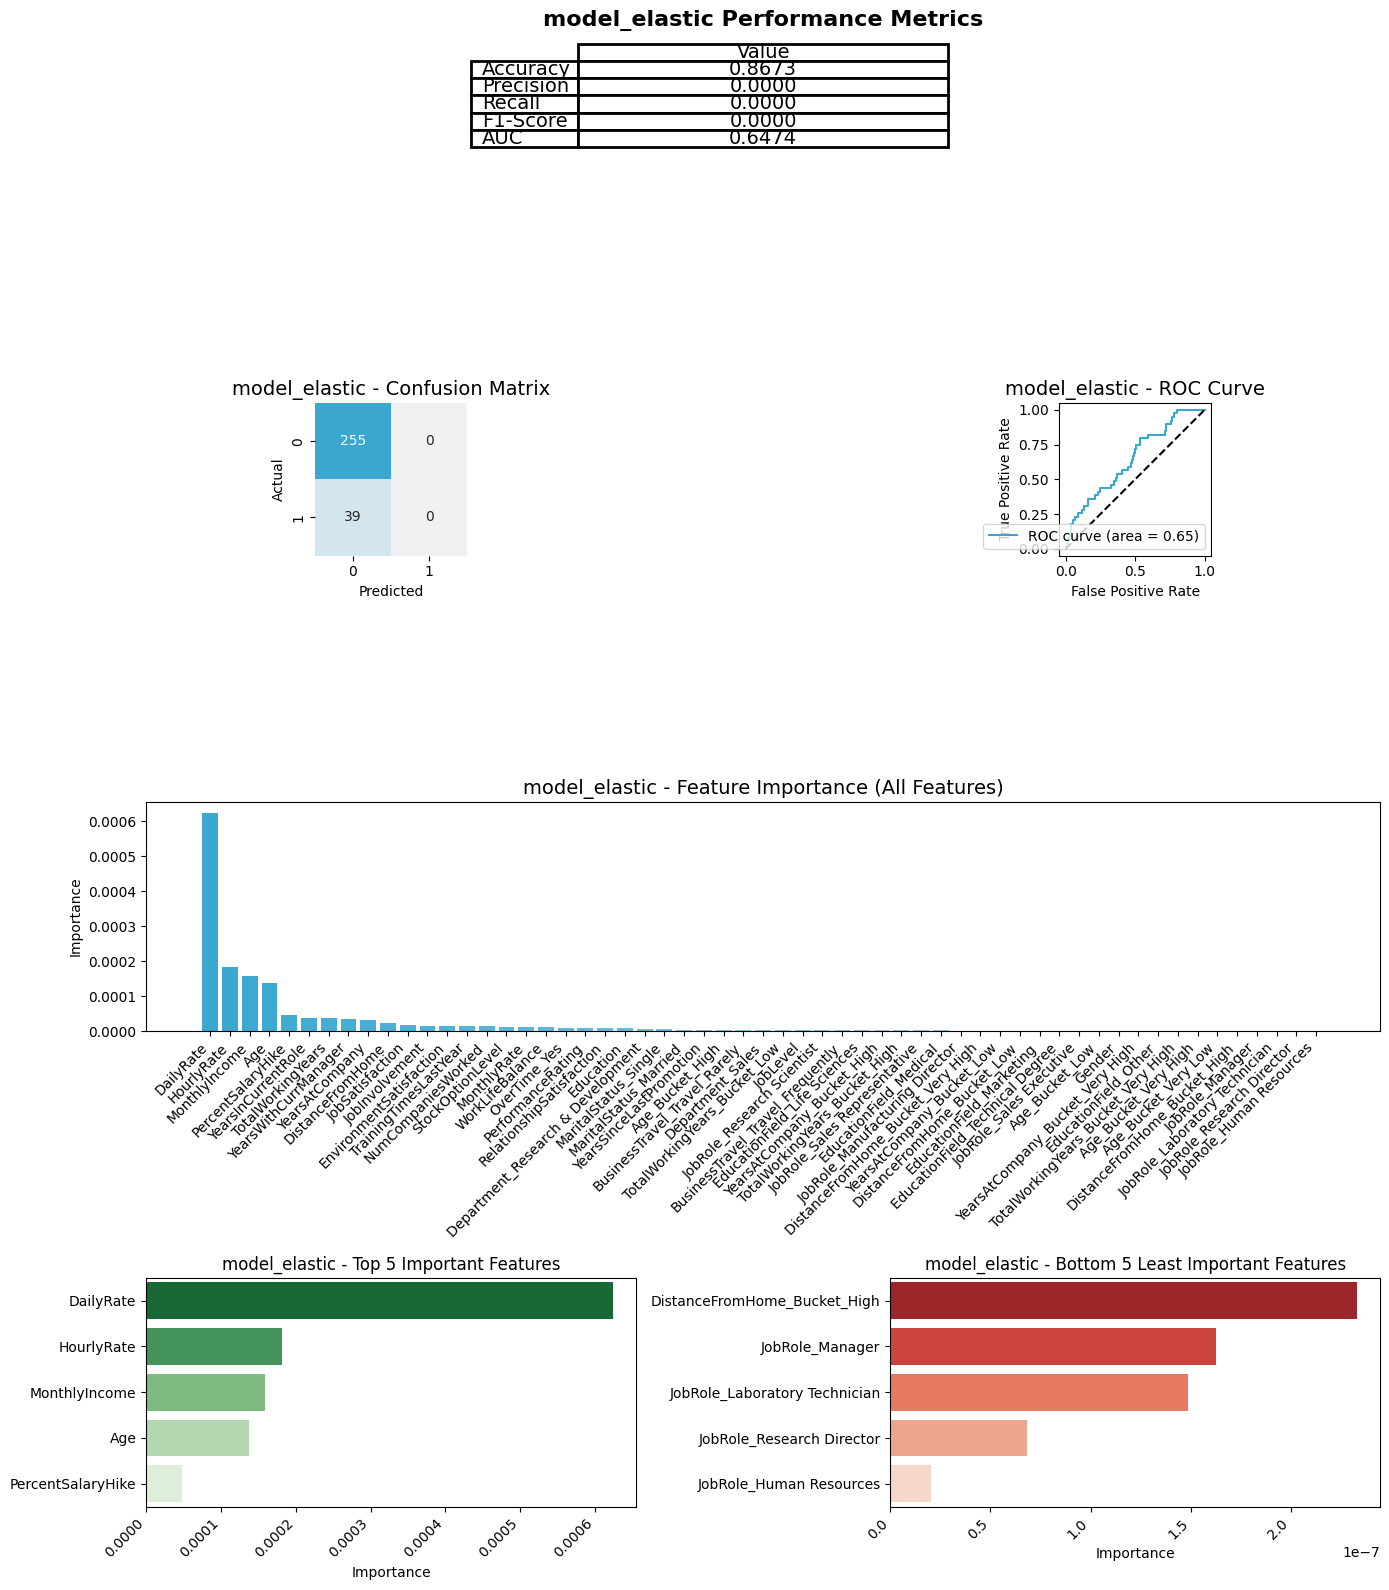

In [26]:

# ElasticNet Regularization
model_elastic = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
model_elastic.fit(X_train, y_train)
summarise_model(model_elastic, X_test, y_test)


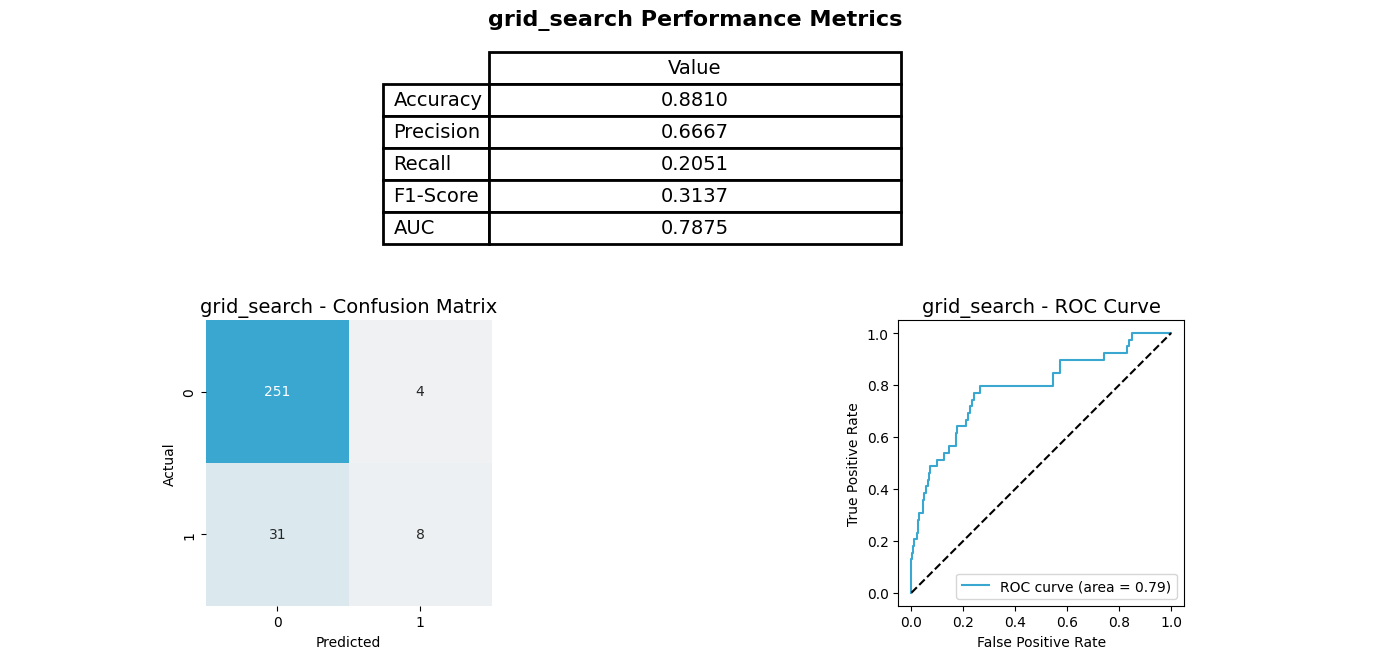

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_model = grid_search.fit(X_train, y_train)

summarise_model(grid_model, X_test, y_test)



/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/sw/wnh5xb2s66v5ljpzzgr4xznc0000gn/T/ipykernel_3962/3529361779.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance[:5], y=top_features[:5], palette='Greens_r', ax=ax4)
/var/folders/sw/wnh5xb2s66v5ljpzzgr4xznc0000gn/T/ipykernel_3962/3529361779.py:115: FutureWarning:

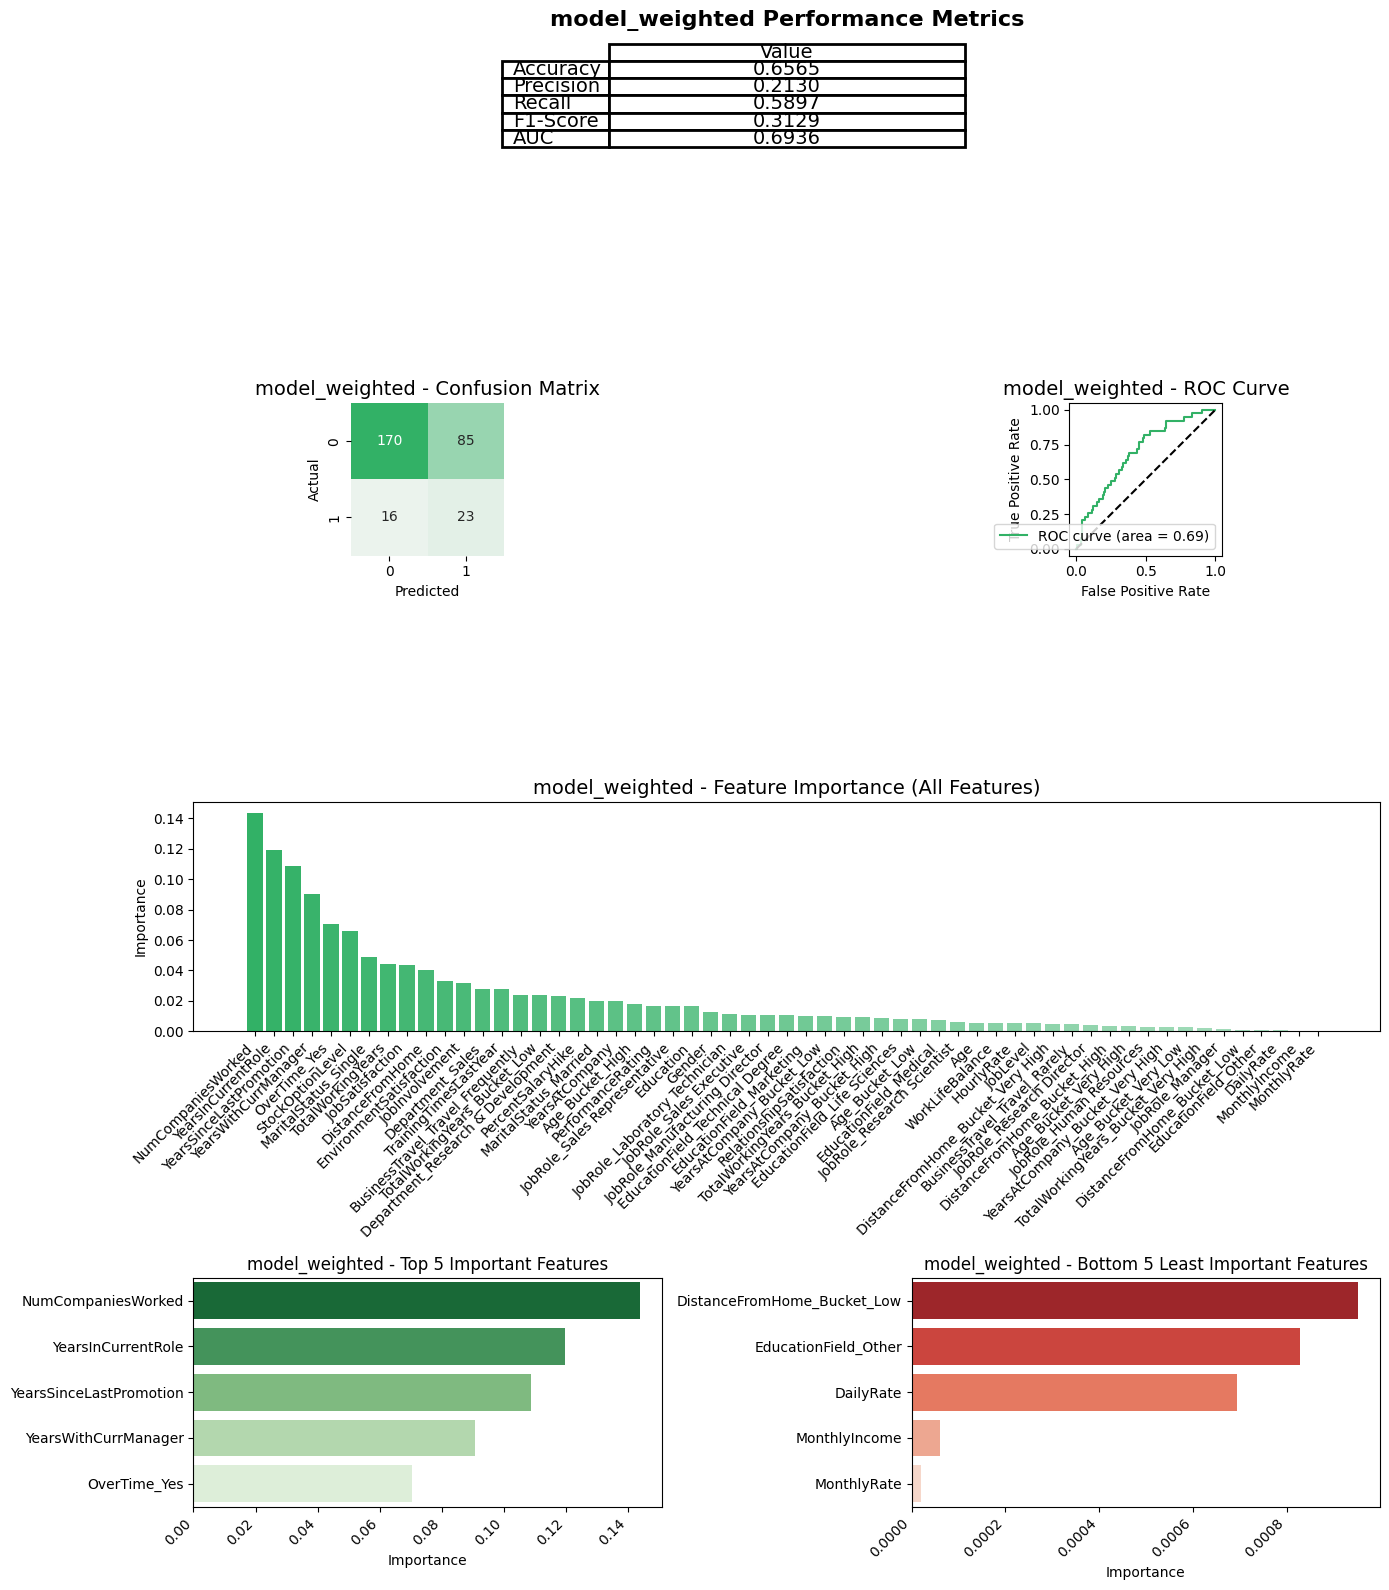

In [28]:
# Logistic Regression with Class Weight Adjustment
model_weighted = LogisticRegression(class_weight='balanced')
model_weighted.fit(X_train, y_train)

summarise_model(model_weighted, X_test, y_test)

In [29]:
from sklearn.feature_selection import RFE

# Feature Selection with RFE
model_rfe = LogisticRegression(max_iter=1000)
rfe = RFE(model_rfe, n_features_to_select=10)
rfe.fit(X_train, y_train )

# Fit and evaluate the model with selected features
y_pred_rfe = rfe.predict(X_test)
print(f"RFE Model Accuracy: {rfe.score(X_test, y_test):.4f}")


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

RFE Model Accuracy: 0.8605


In [74]:
from sklearn.ensemble import BaggingClassifier

# Bagging with Logistic Regression
bagging_model = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=10)
bagging_model.fit(X_train, y_train)

print(f"Bagging Model Accuracy: {bagging_model.score(X_test, y_test):.4f}")


TypeError: BaggingClassifier.__init__() got an unexpected keyword argument 'base_estimator'

In [30]:
# Logistic Regression with default threshold
model_threshold = LogisticRegression()
model_threshold.fit(X_train, y_train)

# Predict probabilities
y_prob = model_threshold.predict_proba(X_test)[:, 1]

# Change the threshold to 0.4
y_pred_adjusted = (y_prob >= 0.4).astype(int)
print(f"Adjusted Threshold Model Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")


Adjusted Threshold Model Accuracy: 0.8673


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
from sklearn.metrics import classification_report, roc_auc_score

model_eval = LogisticRegression()
model_eval.fit(X_train, y_train)

y_pred_eval = model_eval.predict(X_test)
y_prob_eval = model_eval.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred_eval))

# AUC score
auc = roc_auc_score(y_test, y_prob_eval)
print(f"AUC Score: {auc:.4f}")


              precision    recall  f1-score   support

           0       0.87      1.00      0.93       255
           1       0.00      0.00      0.00        39

    accuracy                           0.87       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.75      0.87      0.81       294

AUC Score: 0.7150


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklear

/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

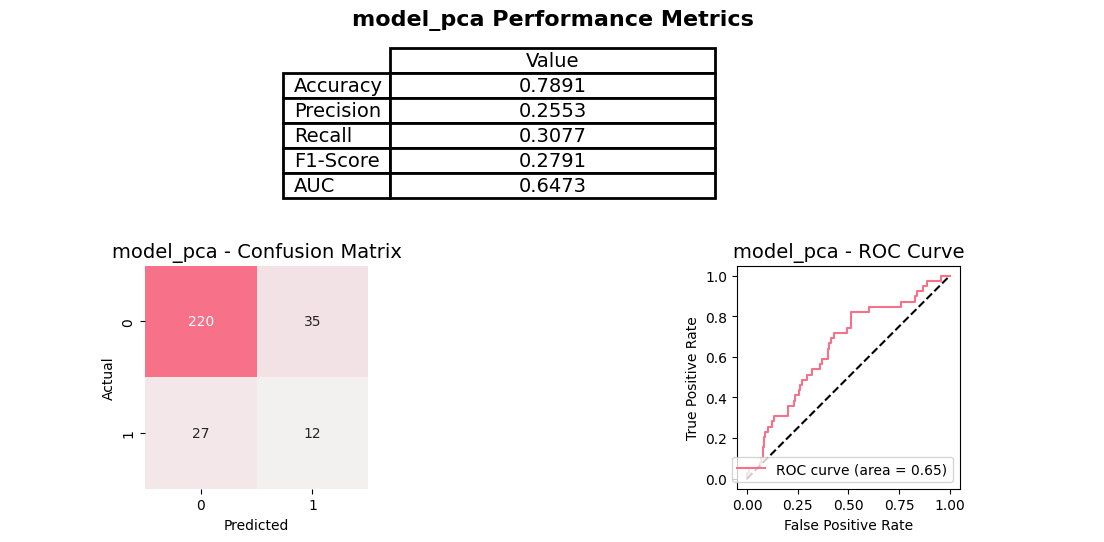

In [32]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Logistic Regression with PCA-transformed features
model_pca = LogisticRegression()
model_pca.fit(X_train_pca, y_train)


summarise_model(model_pca, X_test_pca, y_test)
